# FTP following
This notebook aims to simulate FTP-75 driving cycle on carla, retrieving signals through an async printer on CSV file. Eventually, the Aggressiveness index is computed. Since no standard map contains a straight road long enough to perform the cycle, Town04 is used, assuming that the large radius turns that the vehicle will go through won't affect its speed. 

In [1]:
import carla
from time import perf_counter
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
import asyncio
import numpy as np
import sys
import scipy.fft as fft
import scipy.signal as sgn

try:
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + os.sep + "carla")
except IndexError:
    pass

from agents.navigation.behavior_agent import BehaviorAgent 
from agents.navigation.basic_agent import BasicAgent
from agents.navigation.local_planner import LocalPlanner, RoadOption
from agents.navigation.global_route_planner import GlobalRoutePlanner


 #### Simulation setup

In [2]:
dt = 0.005
sync = True
render = False


In [3]:
# Connect the client and set up bp library and spawn points
client = carla.Client('localhost', 2000) 
client.set_timeout(12.0) 

world = client.get_world()

settings = world.get_settings()
settings.no_rendering_mode = not render
settings.fixed_delta_seconds = dt
settings.synchronous_mode = sync
world.apply_settings(settings)
world = client.load_world('Town04', reset_settings=False)

bp_lib = world.get_blueprint_library() 
spawn_points = world.get_map().get_spawn_points() 

#### Define trajectory

In [4]:
# Get the map and the global route planner
grp = GlobalRoutePlanner(world.get_map(), 2.0)

# Set the plan
route_ids = [75,100,92,272,134,138,130,296,222,212,139,352,336]
waypoints = [spawn_points[idx] for idx in route_ids]
plan = []

# Draw only the spawn points locations that are part of the route
for idx in route_ids:
    world.debug.draw_string(spawn_points[idx].location, str(idx), life_time=15, color=carla.Color(255,0,0))

for i in range(len(waypoints)-1):
    route = grp.trace_route(waypoints[i].location, waypoints[i+1].location)
    route.pop(0)    # prevents first element of every partial route to be added twice, resulting in unexpected
                    # decelerations of the vehicle when it gets to the chosen spawn points
    for x in route:
        plan.append(x)

#### FTP Cycle setup

In [5]:
df = pd.read_csv('FTP-75-cycle/FTP-75.csv')
df.drop(index=0, inplace=True, axis=0)
df = df.dropna(axis='index')
df['Phase'] = df['Phase'].astype(int)
df = df[(df['Phase'] == 1) | (df['Phase'] == 2)]
df.drop('Phase', inplace=True, axis=1)

ftp_v = np.array(df['Set Spd'], dtype=float)
ftp_t = np.array(df['Time'], dtype=float)
# converting from mph to km/h
ftp_v = 1.60934 * ftp_v

#### Agent setup

In [6]:
# NOTE: Avoid running this cell a part from the first time (this is useful to be able to reset the run)
vehicle = None

In [7]:
KP = 0.1
KI = 0.01
KD = 0.01
f_long_update = 10 # Hz
csv_filename = 'collectedData_slowAgent/FTPfollowing_slowAgent_fUpdate={}Hz_PID=({},{},{})_dt={}.csv'.format(f_long_update, KP, KI, KD, dt)

# Reset vehicle
if vehicle is not None:
    vehicle.destroy()
vehicle_bp = bp_lib.find('vehicle.tesla.model3') 
vehicle = world.try_spawn_actor(vehicle_bp, spawn_points[79])
# Set up the agent 
# NOTE: delta time for the longitudinal control is given by its period, i.e. one over its frequency of update.
#       This is used in order to avoid fluctuations of throttle/brake pedal as a consequence of a too small dt
#       for the longitudinal control. 
agent = BasicAgent(vehicle, opt_dict={'dt' : 1 / f_long_update, 'longitudinal_control_dict' : {'K_P': KP, 'K_I': KI, 'K_D': KD, 'dt': 1 / f_long_update}})
agent.set_global_plan(plan=plan, stop_waypoint_creation=False)
agent.ignore_traffic_lights(active=True)
agent.ignore_stop_signs(active=True)
agent.follow_speed_limits(value=False)

In [8]:
velocity_array = []
target_velocity_array = []
throttle_array = []
brake_array = []
time_array = []

#### Definition of init cycle

In [9]:
async def init_cycle():
    # first part of the init cycle makes the vehicle reach and follow a constant speed and then stop.
    # second cycle is used to reset the vehicle's control variables
    target_velocity = 30
    duration = 20
    
    t0 = world.get_snapshot().timestamp.elapsed_seconds
    while True:
        if sync:
            world.tick()

        t = world.get_snapshot().timestamp.elapsed_seconds

        time_array.append(t - t0)

        if time_array[-1] >= duration - 5:
            agent.set_target_speed(0)
        else:
            agent.set_target_speed(target_velocity)
            
        vehicle.apply_control(agent.run_step())

        if time_array[-1] >= duration:
            break       
            
    velocity_array.clear()
    target_velocity_array.clear()
    throttle_array.clear()
    brake_array.clear()
    time_array.clear()
    
    t0 = world.get_snapshot().timestamp.elapsed_seconds
    while True:
        if sync:
            world.tick()
        
        t = world.get_snapshot().timestamp.elapsed_seconds
        time_array.append(t - t0)
        vehicle.apply_control(carla.VehicleControl(throttle=0, brake=0.3, steer=0))

        if time_array[-1] >= 5:
            vehicle.apply_control(carla.VehicleControl(throttle=0, brake=0, steer=0))
            break   

    time_array.clear()

#### Definition of async printer and main loop

In [10]:
async def save_to_csv(FTP_loop_task, filename):
    with open(filename, mode='w') as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Time', 'Velocity', 'Target Velocity', 'Throttle', 'Brake'])
        while True:
            await asyncio.sleep(0)  # needed to avoid blocking the event loop
            # if all the arrays have at least one value
            if velocity_array and target_velocity_array and throttle_array and brake_array and time_array:
                # find how many tuples can be written
                min_len = min(len(velocity_array), len(target_velocity_array), len(throttle_array), len(brake_array), len(time_array))
                # write the tuples
                for i in range(min_len):
                    writer.writerow([time_array.pop(0), velocity_array.pop(0), target_velocity_array.pop(0), throttle_array.pop(0), brake_array.pop(0)])
            elif FTP_loop_task.done():
                break

In [11]:
async def FTP_loop():  
    T_S = perf_counter()
    t0 = world.get_snapshot().timestamp.elapsed_seconds
    t1 = t0

    control = carla.VehicleControl(throttle=0, brake=0, steer=0)
    vehicle.apply_control(control)

    while True:
        # Retrieve time and velocity from the simulation. Throttle and brake are computed by
        # the agent locally, so they don't need to be retrieved from the simulation. 
        t = world.get_snapshot().timestamp.elapsed_seconds
        target_velocity = ftp_v[int(10 * round(t - t0, 1))]
        velocity = vehicle.get_velocity()
        # Collect signals
        velocity_array.append(3.6 * np.sqrt((float(velocity.x)) ** 2 + (float(velocity.y)) ** 2 + (float(velocity.z)) ** 2))
        target_velocity_array.append(target_velocity)
        throttle_array.append(control.throttle)
        brake_array.append(control.brake)
        time_array.append(t - t0)
        
        # Go ahead with simulation
        if sync:
            world.tick()
        # Update target speed (needed by the agent to run a step)
        agent.set_target_speed(target_velocity)
        # Update the control that will be applied        
        if t - t1 >= 1 / f_long_update:
            t1 = t
            control = agent.run_step()
        else:
            control.steer = agent.run_step().steer
        # Apply control
        vehicle.apply_control(control)
        
        # Check wheter simulation is finished
        if time_array[-1] >= ftp_t[-1]:
            break 
        
        # Yield control
        await asyncio.sleep(0)
        
    print('Total computation time: ', perf_counter() - T_S)

In [12]:
await init_cycle()

In [13]:
main_task = asyncio.create_task(FTP_loop())
save_task = asyncio.create_task(save_to_csv(main_task, csv_filename))
done, pending = await asyncio.wait([main_task, save_task], return_when=asyncio.ALL_COMPLETED)



Total computation time:  967.389289


#### Plot original diagrams

In [15]:
signals_df = pd.read_csv(csv_filename, sep=',', header=0)
x_t = np.array(signals_df['Time'], dtype=float)
y_rv = np.array(signals_df['Velocity'], dtype=float)
y_tv = np.array(signals_df['Target Velocity'], dtype=float)
y_tp = np.array(signals_df['Throttle'], dtype=float)
y_bp = np.array(signals_df['Brake'], dtype=float)

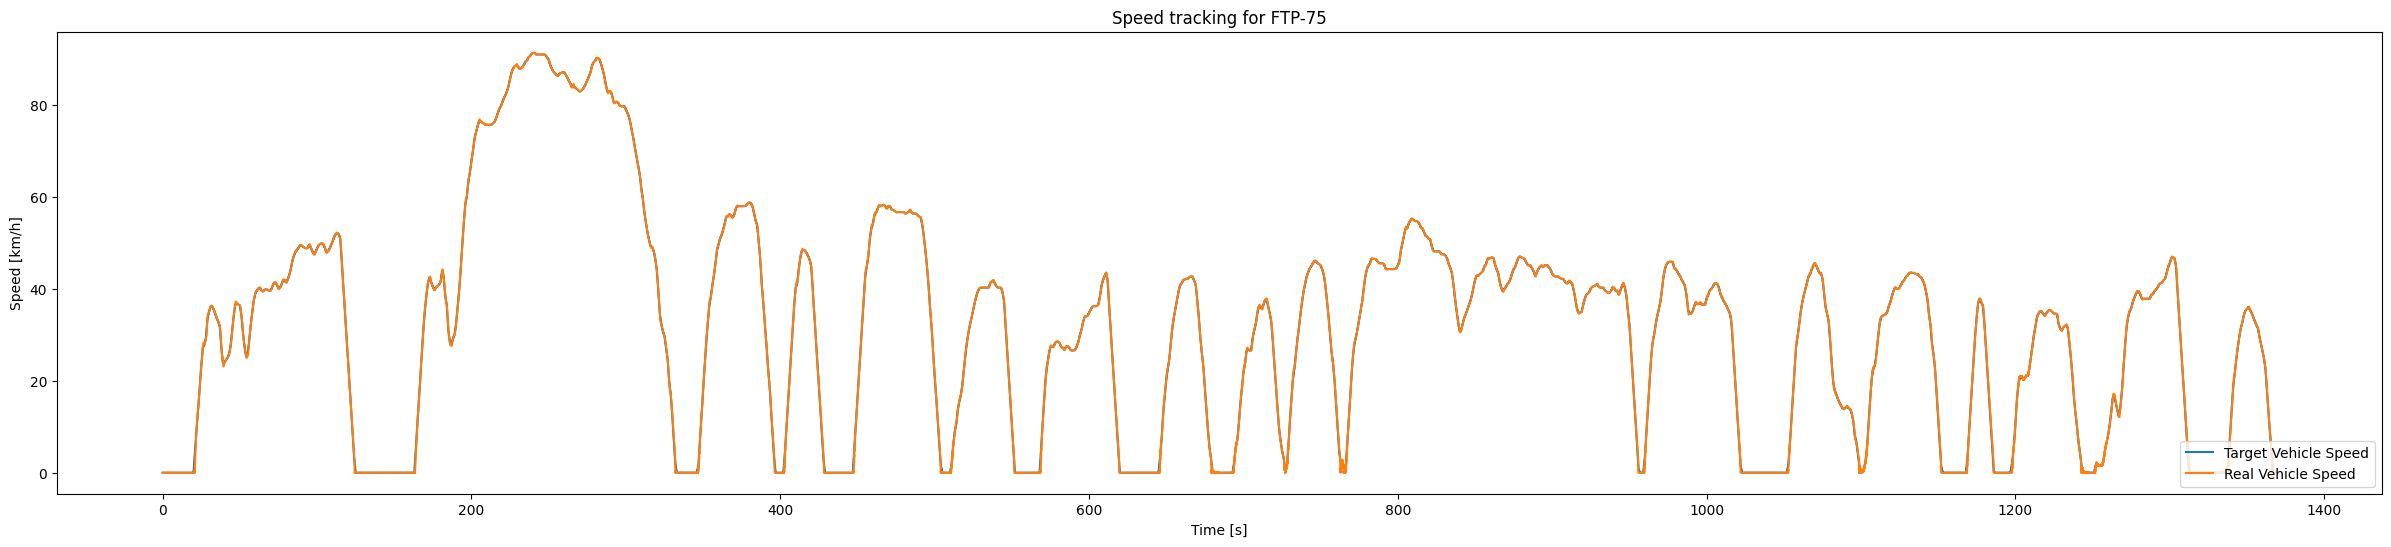

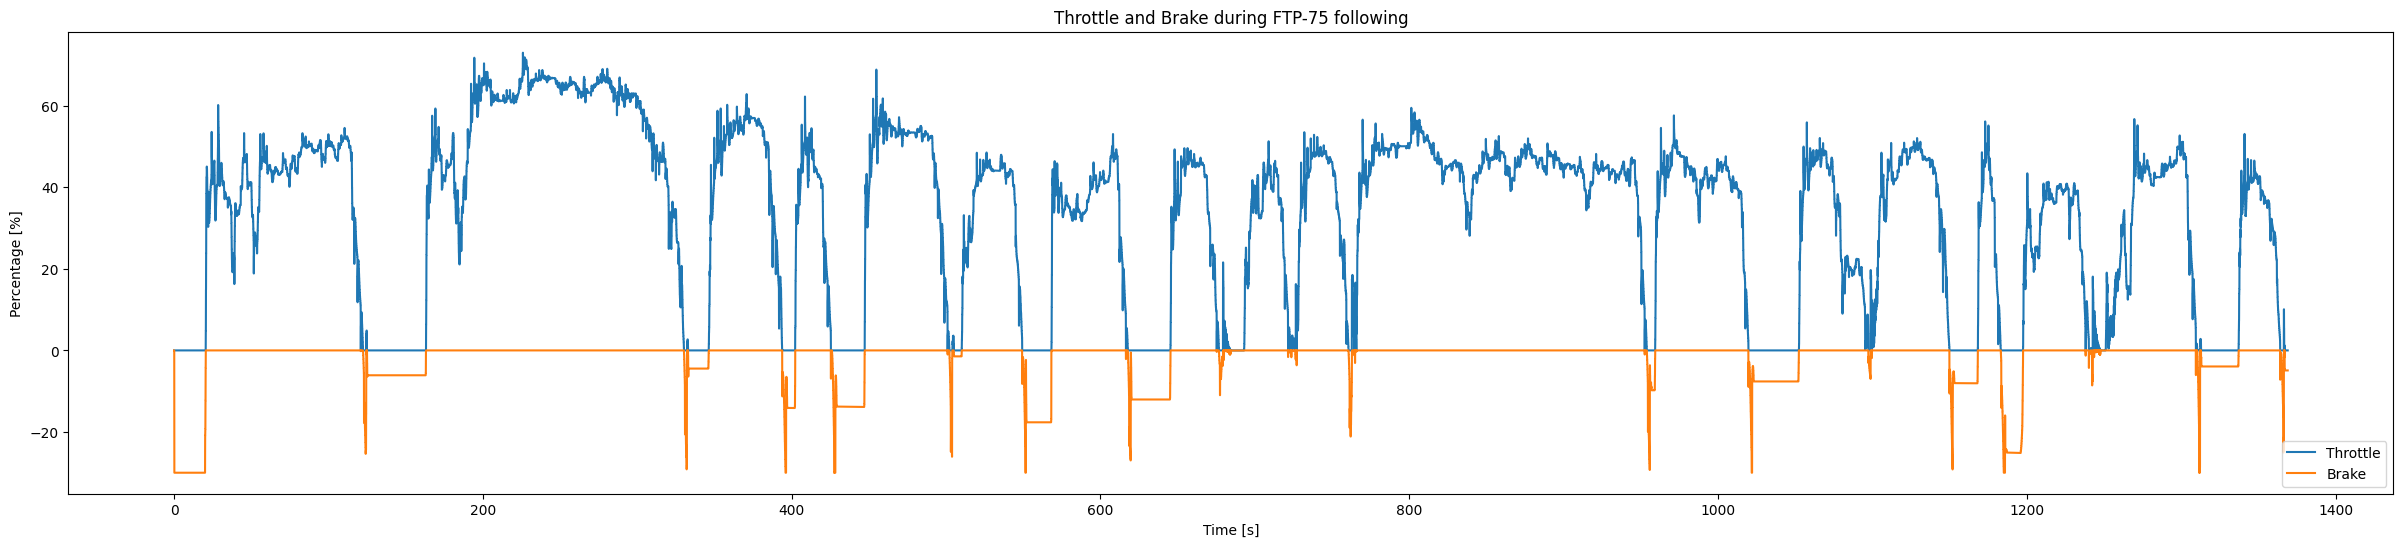

In [16]:
plt.figure(figsize=(30,6))
plt.title("Speed tracking for FTP-75")
plt.ylabel("Speed [km/h]")
plt.xlabel("Time [s]")
plt.plot(x_t, y_tv, label='Target Vehicle Speed')
plt.plot(x_t, y_rv, label='Real Vehicle Speed')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(30,6))
plt.title("Throttle and Brake during FTP-75 following")
plt.ylabel("Percentage [%]")
plt.xlabel("Time [s]")
plt.plot(x_t, 100 * y_tp, label='Throttle')
plt.plot(x_t, -100 * y_bp, label='Brake')   
plt.legend(loc="lower right")
plt.show()